In [1]:
import pickle
import os

import bakeoff_opt
import matplotlib.pyplot as plt
import numpy as np
import seaborn

import nb_helpers

seaborn.set()

In [2]:
filename = "timeit_results.pkl"
seed = 798031893
nodes_sizes_by_k = {
    3: (2, 4, 8, 16, 20, 24, 28, 32, 64),
    9: (2, 4, 8, 12, 16, 20, 24, 28, 32, 64),
    33: (2, 4, 8, 10, 12, 14, 16, 32, 64),
    129: (2, 4, 6, 8, 12, 16, 32, 64),
    513: (2, 3, 4, 6, 8, 16, 32, 64),
}
fns = (
    bakeoff_opt.forall1,
    bakeoff_opt.spread1,
    bakeoff_opt.serial,
    bakeoff_opt.vs_algorithm64,
)

In [3]:
# Load previous results from disk.
# NOTE: This is a bad idea if these benchmarks are being
#       run on multiple machines.
if os.path.isfile(filename):
    with open(filename, "rb") as file_obj:
        by_size = pickle.load(file_obj)
else:
    by_size = {}

In [4]:
for num_s_vals, nodes_sizes in nodes_sizes_by_k.items():
    for num_nodes in nodes_sizes:
        nodes, s_vals = nb_helpers.generate_nodes(num_nodes, num_s_vals, seed)
        for fn in fns:
            key = (nb_helpers.fn_name(fn), seed, num_nodes, num_s_vals)
            if key in by_size:
                continue            
            by_size[key] = %timeit -o -q fn(nodes, s_vals)

In [5]:
# Store results back to disk.
with open(filename, "wb") as fh:
    pickle.dump(by_size, fh)

In [6]:
def plot_data(ax, fns, seed, nodes_sizes_by_k, by_size, num_s_vals):
    nodes_sizes = nodes_sizes_by_k[num_s_vals]
    for fn in fns:
        x_vals = []
        y_vals = []
        y_below = []
        y_above = []
        for num_nodes in nodes_sizes:
            key = (nb_helpers.fn_name(fn), seed, num_nodes, num_s_vals)
            timeit_result = by_size[key]
            # 2 std deviations ~= 95%
            below = timeit_result.average - 2.0 * timeit_result.stdev
            above = timeit_result.average + 2.0 * timeit_result.stdev
            # If the running time goes non-positive, ignore the datapoint
            if below <= 0.0:
                continue
            
            x_vals.append(num_nodes)
            y_vals.append(timeit_result.average)
            y_below.append(below)
            y_above.append(above)

        line, = ax.loglog(x_vals, y_vals, marker="o", label=fn.__name__)
        ax.fill_between(
            x_vals, y_below, y_above, alpha=0.5, color=line.get_color()
        )

    ax.set_xscale("log", basex=2)
    ax.set_yscale("log", basey=2)
    ax.set_title(f"Number of Input Values: {num_s_vals}")
    ax.set_xlabel("Number of Nodes")
    ax.set_ylabel("Average Evaluation Time (s)")
    ax.legend()

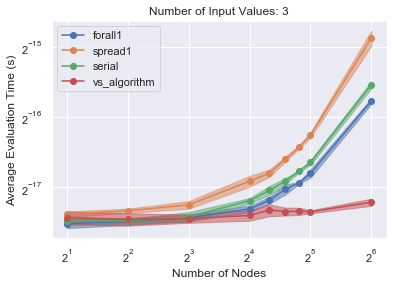

In [7]:
figure = plt.figure()
plot_data(figure.gca(), fns, seed, nodes_sizes_by_k, by_size, 3)

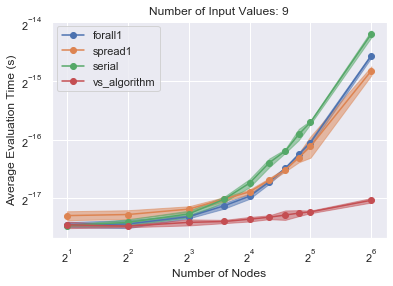

In [8]:
figure = plt.figure()
plot_data(figure.gca(), fns, seed, nodes_sizes_by_k, by_size, 9)

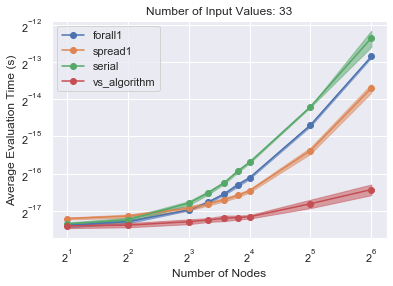

In [9]:
figure = plt.figure()
plot_data(figure.gca(), fns, seed, nodes_sizes_by_k, by_size, 33)

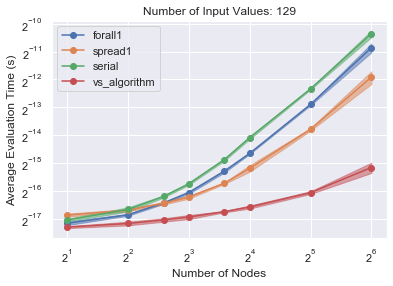

In [10]:
figure = plt.figure()
plot_data(figure.gca(), fns, seed, nodes_sizes_by_k, by_size, 129)

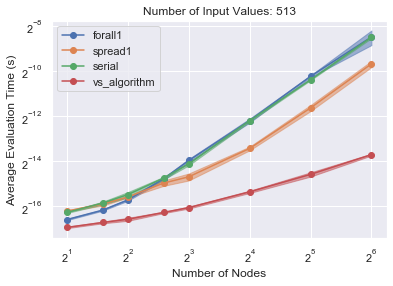

In [11]:
figure = plt.figure()
plot_data(figure.gca(), fns, seed, nodes_sizes_by_k, by_size, 513)

## Constant vs. Log-Linear Regimes

Note that for each `k` value, there seems to be a number of nodes `N` after which the `forall1` and `serial` lines go from constant to log-linear with slope equal to 2 (i.e. quadratic). As `k` increases, this value appears to decrease:

- `k = 3`, regime change when `N` is between `16` and `32`
- `k = 9`, regime change when `N` is between `16` and `32`
- `k = 33`, regime change when `N` is between `8` and `16`
- `k = 129`, regime change when `N = 8`
- `k = 513`, regime change when `N = 4`